# Laboratorio 4

- Mark Albrand 21004
- Jimena Hernández 21199

## Mejorando el Análisis de Sentimientos con LSTM y Características Adicionales

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np


### Importación

In [2]:
max_features = 50000

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

In [4]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

25000 train sequences
25000 test sequences


In [5]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

### Preprocesamiento

In [6]:
word_index = imdb.get_word_index()
word_index_inv = {v: k for k, v in word_index.items()}

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
for w in X_train[10]:
    print(word_index_inv.get(w - 3, '?'), end=' ')

? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made maléfique was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is complimented by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named carrère sent to prison for fraud he is put in a cell with three others the quietly insane lassalle body building transvestite marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old journal after translating part of it they soon realise its magical power

#### Longitud uniforme


In [8]:
maxlen = 80

In [9]:
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)

In [10]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\nY_train shape: {y_train.shape}\nY_test shape: {y_test.shape}")

X_train shape: (25000, 80)
X_test shape: (25000, 80)
Y_train shape: (25000,)
Y_test shape: (25000,)


#### Extracción de características adicionales

In [11]:
# Se seleccionan algunas palabras positivas y negativas vistas en las reseñas
positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'wonderful', 'brilliant', 'loved', 'recommend', 'lovely', 'memorable']
negative_words = ['bad', 'terrible', 'awful', 'hate', 'worst', 'horrible', 'poor', 'claustrophobic', 'frightening', 'boring', 'lame']

# Convertir las listas de palabras a índices
positive_indices = [word_index[word] for word in positive_words if word in word_index and word_index[word] < max_features]
negative_indices = [word_index[word] for word in negative_words if word in word_index and word_index[word] < max_features]

#Función para extraer características de las secuencias
def extract_features(sequences):
    features = []
    for seq in sequences:
        length = len(seq)  # Longitud de la secuencia
        pos_count = sum(1 for word in seq if word in positive_indices)  # Cantidad de palabras positivas
        neg_count = sum(1 for word in seq if word in negative_indices)  # Cantidad de palabras negativas
        
        pos_ratio = pos_count / length if length > 0 else 0  # Proporción de palabras positivas
        neg_ratio = neg_count / length if length > 0 else 0  # Proporción de palabras negativas
        
        features.append([length, pos_ratio, neg_ratio])  # Se agregan las características a la lista
    return np.array(features)

train_features = extract_features(X_train)  # Se extraen las características de las secuencias de entrenamiento
test_features = extract_features(X_test)  # Se extraen las características de las secuencias de prueba

In [12]:
# Unir las características extraídas con las secuencias
X_train = np.concatenate([X_train, train_features], axis=1)
X_test = np.concatenate([X_test, test_features], axis=1)

### Modelo

In [13]:
modelo = Sequential()

modelo.add(Embedding(50000, 128))
modelo.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
modelo.add(Dense(1, activation='sigmoid'))

Ya que este es un problema de clasificación binaria, la mejor función de pérdida es la "binary_crossentropy".  También se utiliza el optimizador "Adam" que es uno de los mejores.  Siempre es de recordar que si es necesario afinar más el modelo, se pueden probar otras.

In [14]:
modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Ahora sí, a iniciar el entrenamiento.  Aún con una GPU se tardará bastante tiempo!

In [15]:
history = modelo.fit(
    X_train, y_train,
    batch_size = 32,
    epochs = 15,
    verbose = 2,
    validation_data = (X_test, y_test)
)

Epoch 1/15
782/782 - 47s - 60ms/step - accuracy: 0.7837 - loss: 0.4651 - val_accuracy: 0.8178 - val_loss: 0.4009
Epoch 2/15
782/782 - 43s - 55ms/step - accuracy: 0.8840 - loss: 0.2932 - val_accuracy: 0.8309 - val_loss: 0.3854
Epoch 3/15
782/782 - 41s - 52ms/step - accuracy: 0.9256 - loss: 0.2009 - val_accuracy: 0.8331 - val_loss: 0.4147
Epoch 4/15
782/782 - 51s - 66ms/step - accuracy: 0.9491 - loss: 0.1415 - val_accuracy: 0.8174 - val_loss: 0.5400
Epoch 5/15
782/782 - 51s - 65ms/step - accuracy: 0.9670 - loss: 0.0972 - val_accuracy: 0.8236 - val_loss: 0.5680
Epoch 6/15
782/782 - 47s - 59ms/step - accuracy: 0.9764 - loss: 0.0669 - val_accuracy: 0.8193 - val_loss: 0.7219
Epoch 7/15
782/782 - 43s - 56ms/step - accuracy: 0.9860 - loss: 0.0439 - val_accuracy: 0.8150 - val_loss: 0.7383
Epoch 8/15
782/782 - 40s - 52ms/step - accuracy: 0.9909 - loss: 0.0305 - val_accuracy: 0.8159 - val_loss: 0.7472
Epoch 9/15
782/782 - 40s - 51ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.8150 - 

In [16]:
#modelo.save("Anal_Sentimiento.h5")

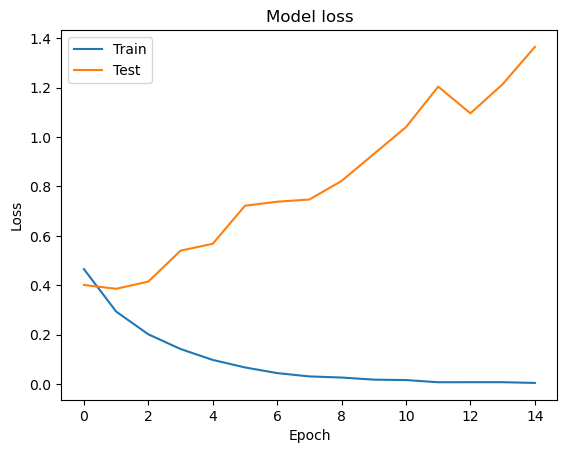

In [17]:
# Graficar loss y val_loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

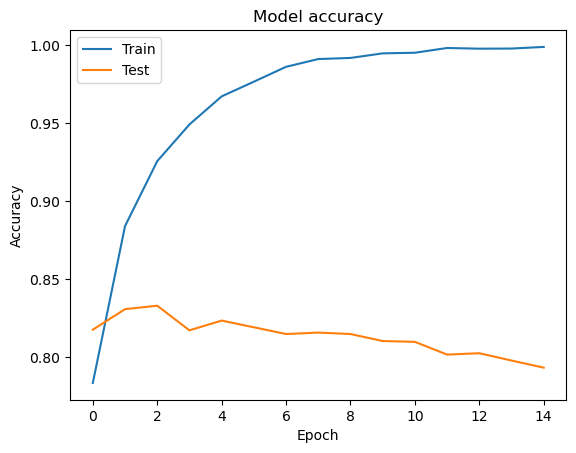

In [18]:
# Graficar accuracy y val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
# from tensorflow.keras.models import load_model
# modelo = load_model("Anal_Sentimiento.h5")

OK, ahora a evaluar la exactitud del modelo:

In [20]:
perdida, exactitud = modelo.evaluate(
    X_test, y_test,
    batch_size = 32,
    verbose = 2
)

print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)

782/782 - 7s - 9ms/step - accuracy: 0.7935 - loss: 1.3653
Pérdida de la Prueba: 1.3653278350830078
Exactitud de la Prueba (Test accuracy): 0.7934799790382385


In [21]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
# Retrieve the training sequences.
(X_train, _), _ = tf.keras.datasets.imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)
# Retrieve the word index file mapping words to indices
word_index = tf.keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in X_train[0])

In [22]:
decoded_sequence

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh